# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

*** Please note that BERT was used with Nvidia GPU (RTX 3080Ti) *** Do not run the training code again, load embeddings data ("features_4.npz") instead

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews[df_reviews.isnull().any(axis=1)]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [8]:
np.sort(df_reviews['start_year'].unique())

array([1894, 1895, 1897, 1902, 1903, 1908, 1909, 1910, 1912, 1913, 1914,
       1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])

This data set only has movies until 2010 and only 3 in 2010, so likely it doesn't cover all movies in 2010. Only two rows contain null values in the average_rating and votes columns. Those columns will not be used for the model training, so the two rows can stay.

## EDA

Let's check the number of movies and reviews over years.

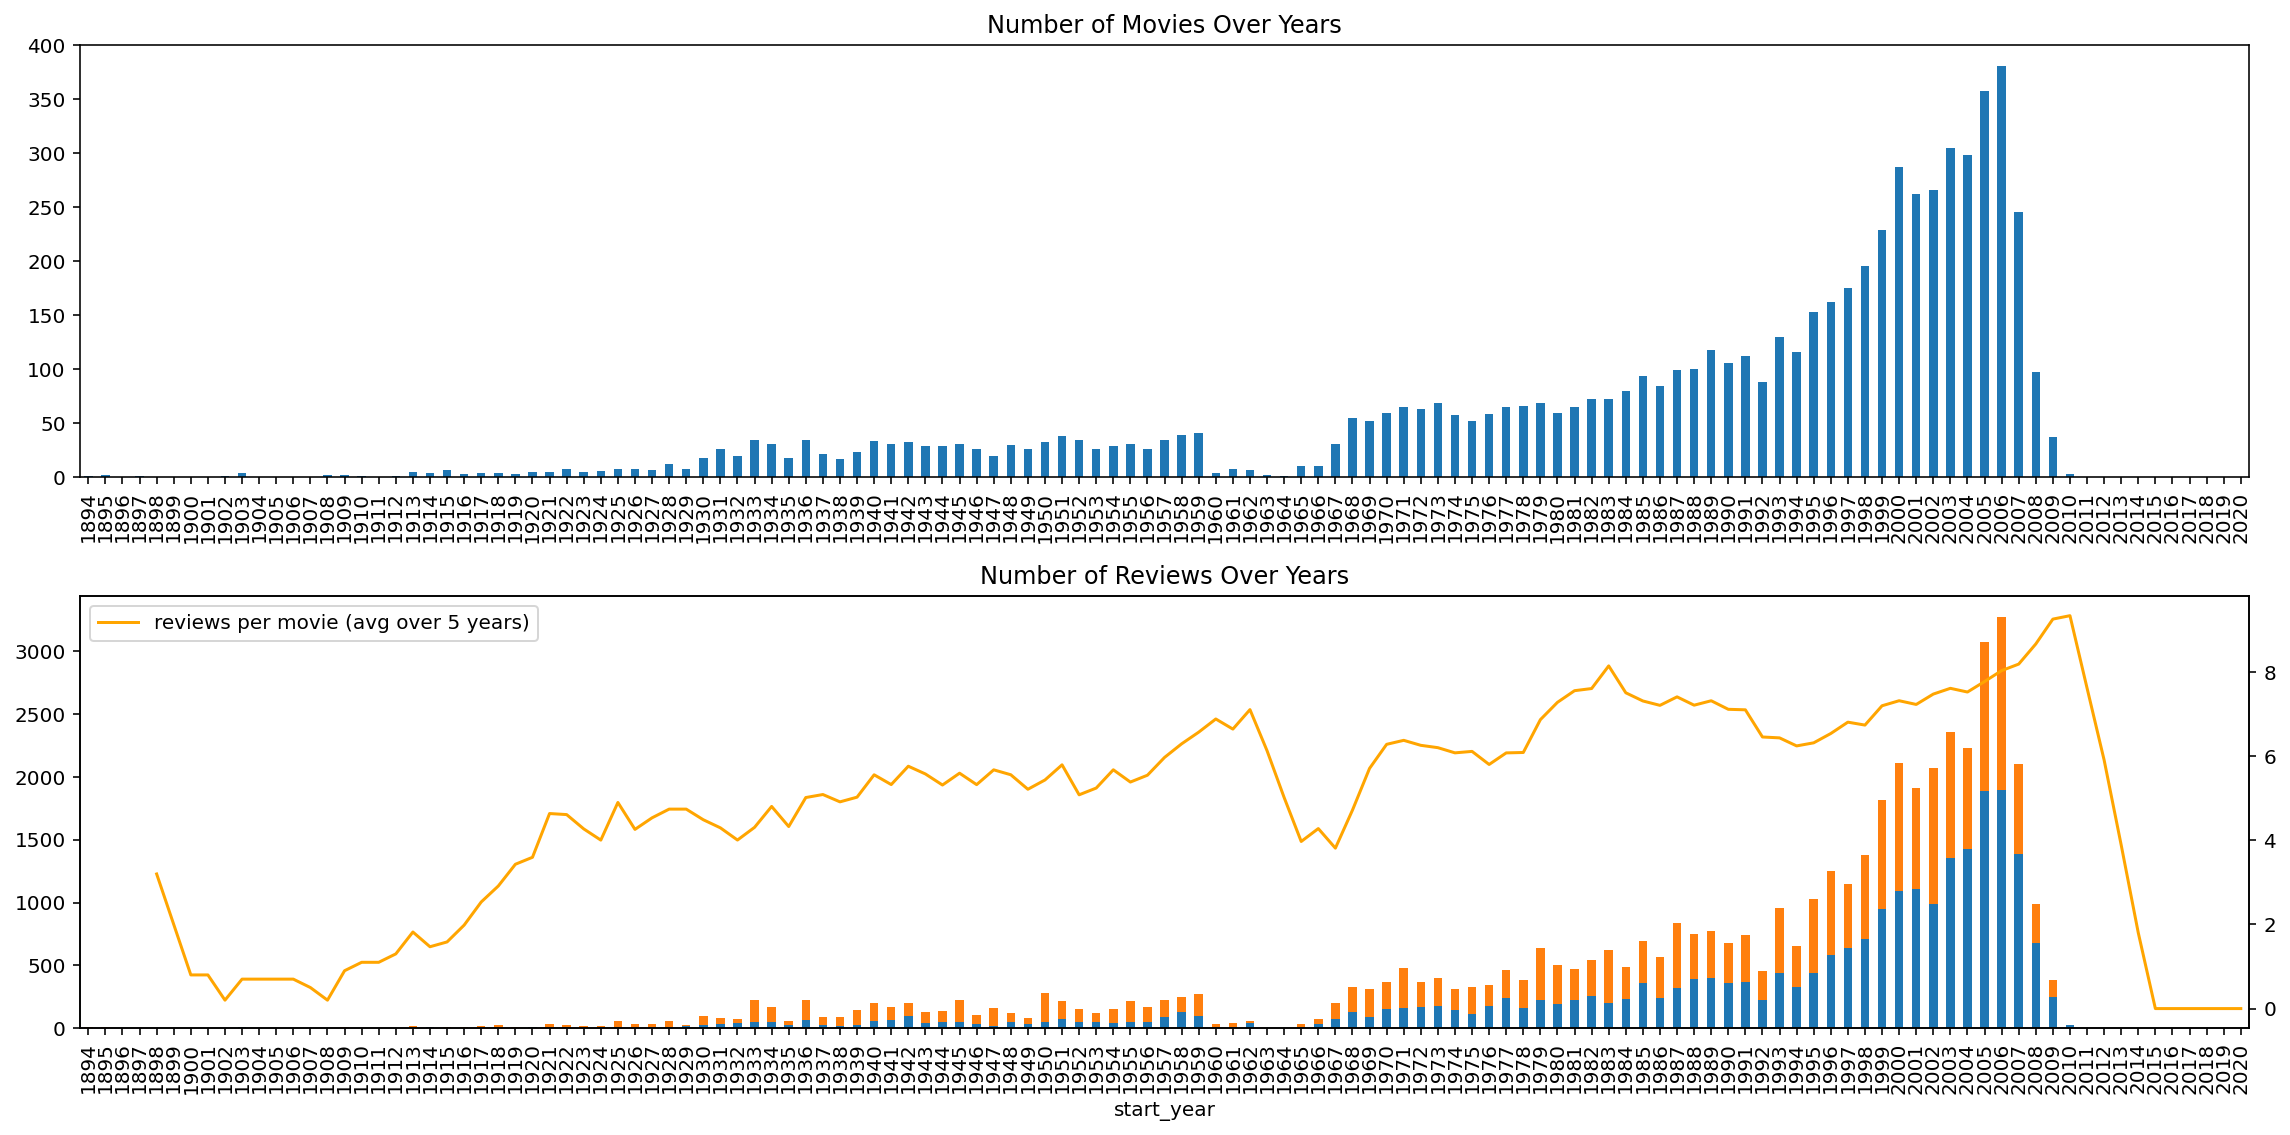

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

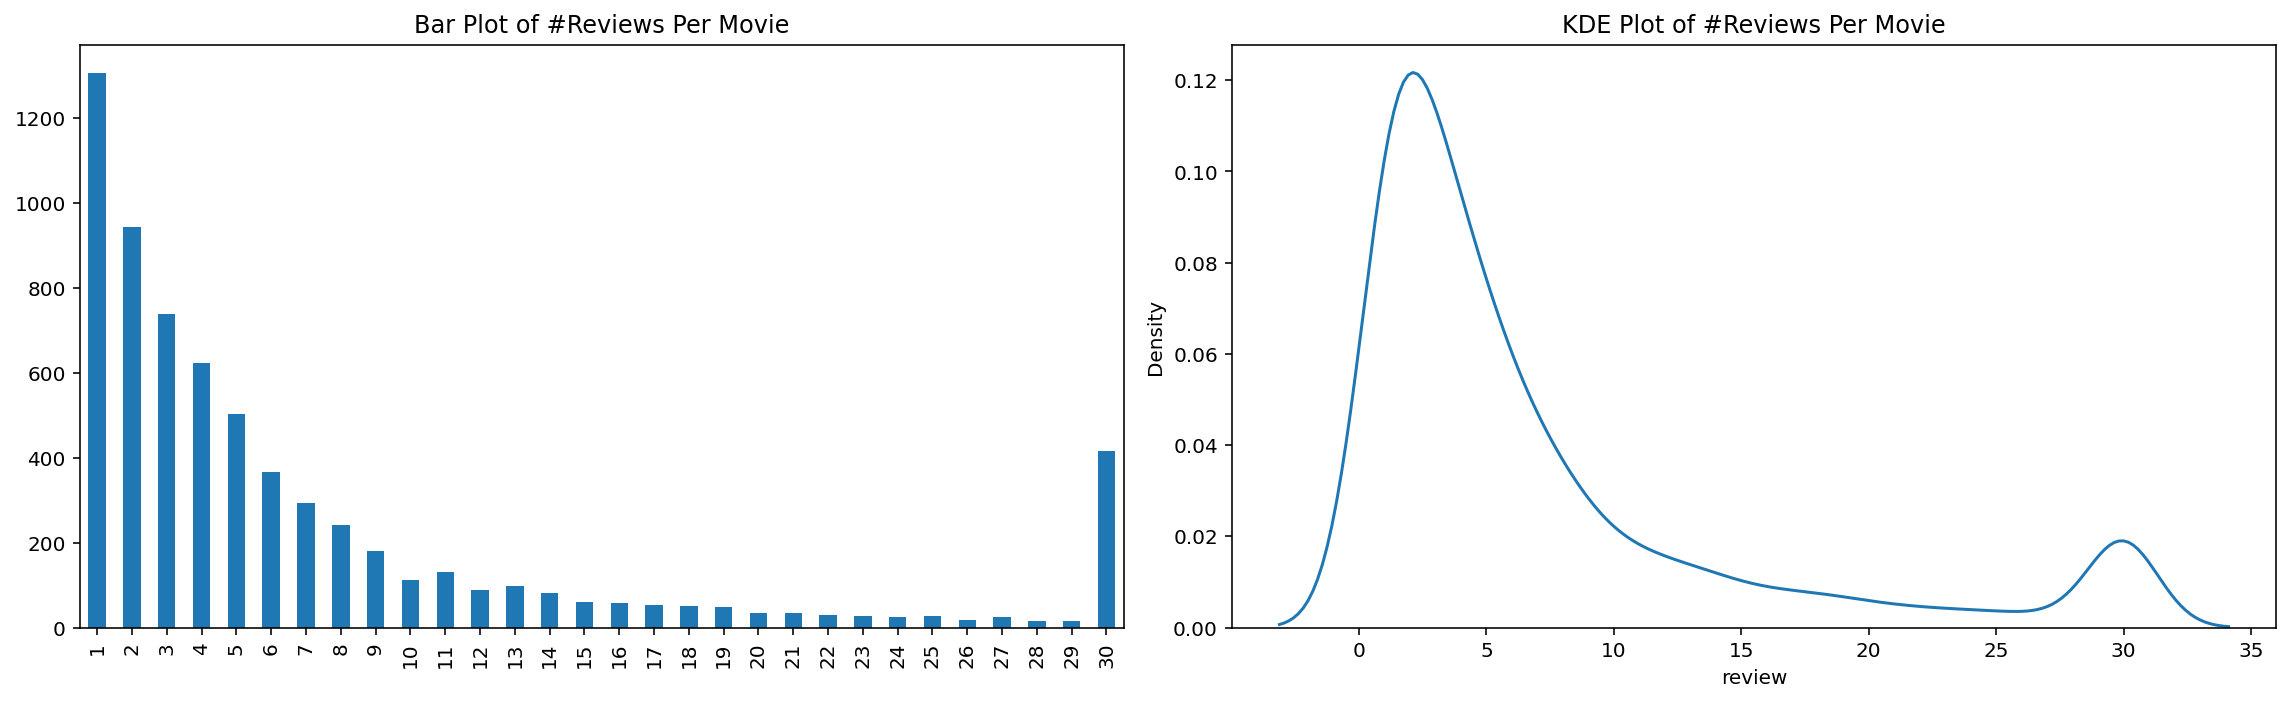

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The number of movie reviews per year alings with the number of movies produced per year. The number of movies produced each year increased exponentially from 1980s to 2006 then dropped gradually from 2008 to 2009.
Most movies have 1 review and the majority of movies have 5 reviews or less, and this decreases gradually until 30 reviews where there's a spike to 2% of movies having that many reviews.

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

In [12]:
# Check the balance of positive and negative reviews in the training set
train_class_distribution = df_reviews[df_reviews['ds_part'] == 'train']['pos'].value_counts()

# Check the balance of positive and negative reviews in the testing set
test_class_distribution = df_reviews[df_reviews['ds_part'] == 'test']['pos'].value_counts()

train_class_distribution, test_class_distribution

(0    11912
 1    11884
 Name: pos, dtype: int64,
 0    11803
 1    11732
 Name: pos, dtype: int64)

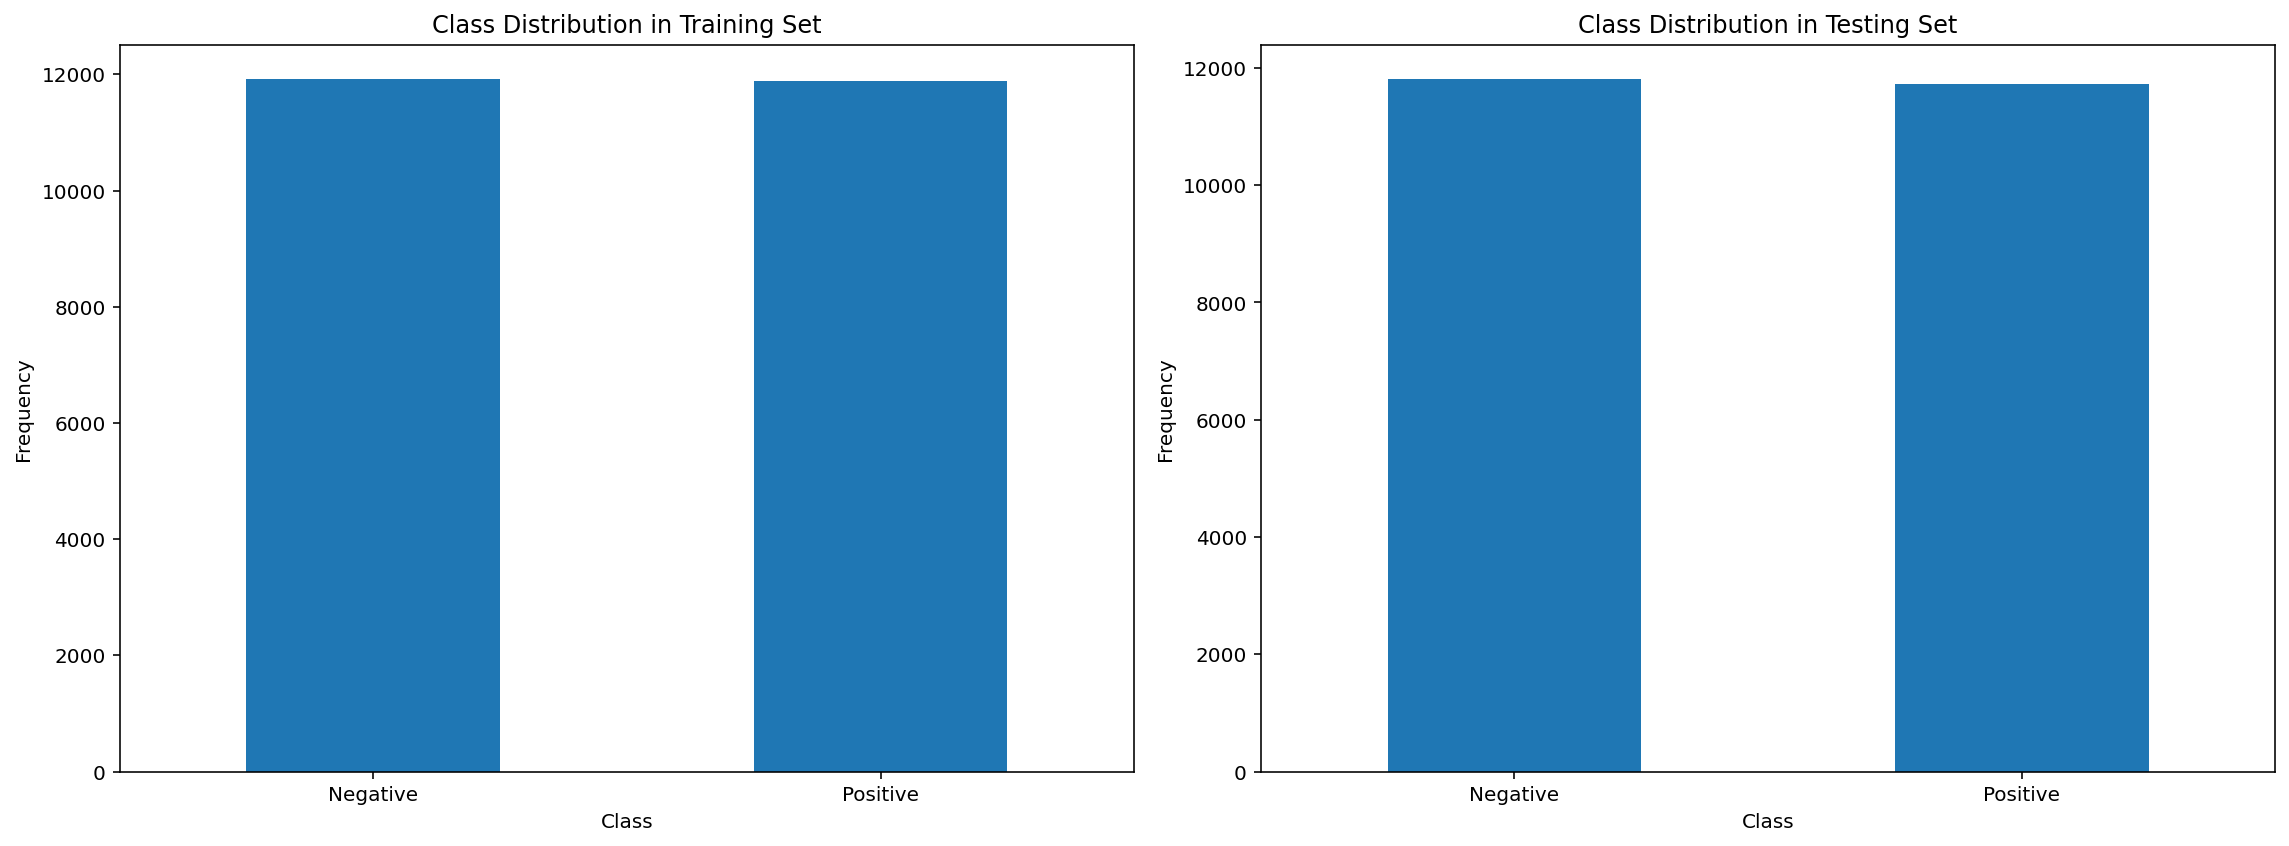

In [13]:
# Plot the class distribution in the training set
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Set')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)

# Plot the class distribution in the testing set
plt.subplot(1, 2, 2)
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Testing Set')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)

plt.tight_layout()
plt.show()

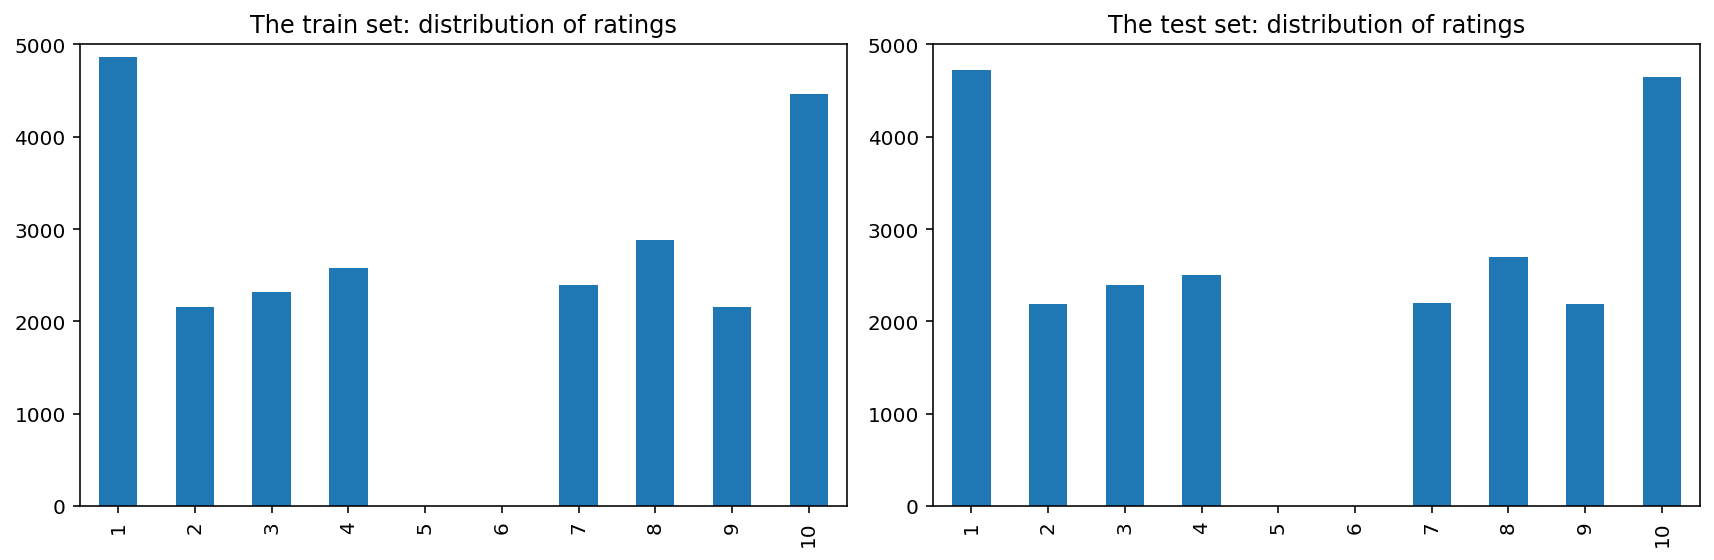

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The class distribution of positive and negative reviews is nearly balanced in both training and testing sets, which is good for training a machine learning model for sentiment analysis.
Rating distributions are similar in training and test sets. Both sets have the most common ratings as 1 and 10, with neglible number of ratings of 5 & 6, and 2-4 and 7-9 trend similarly.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


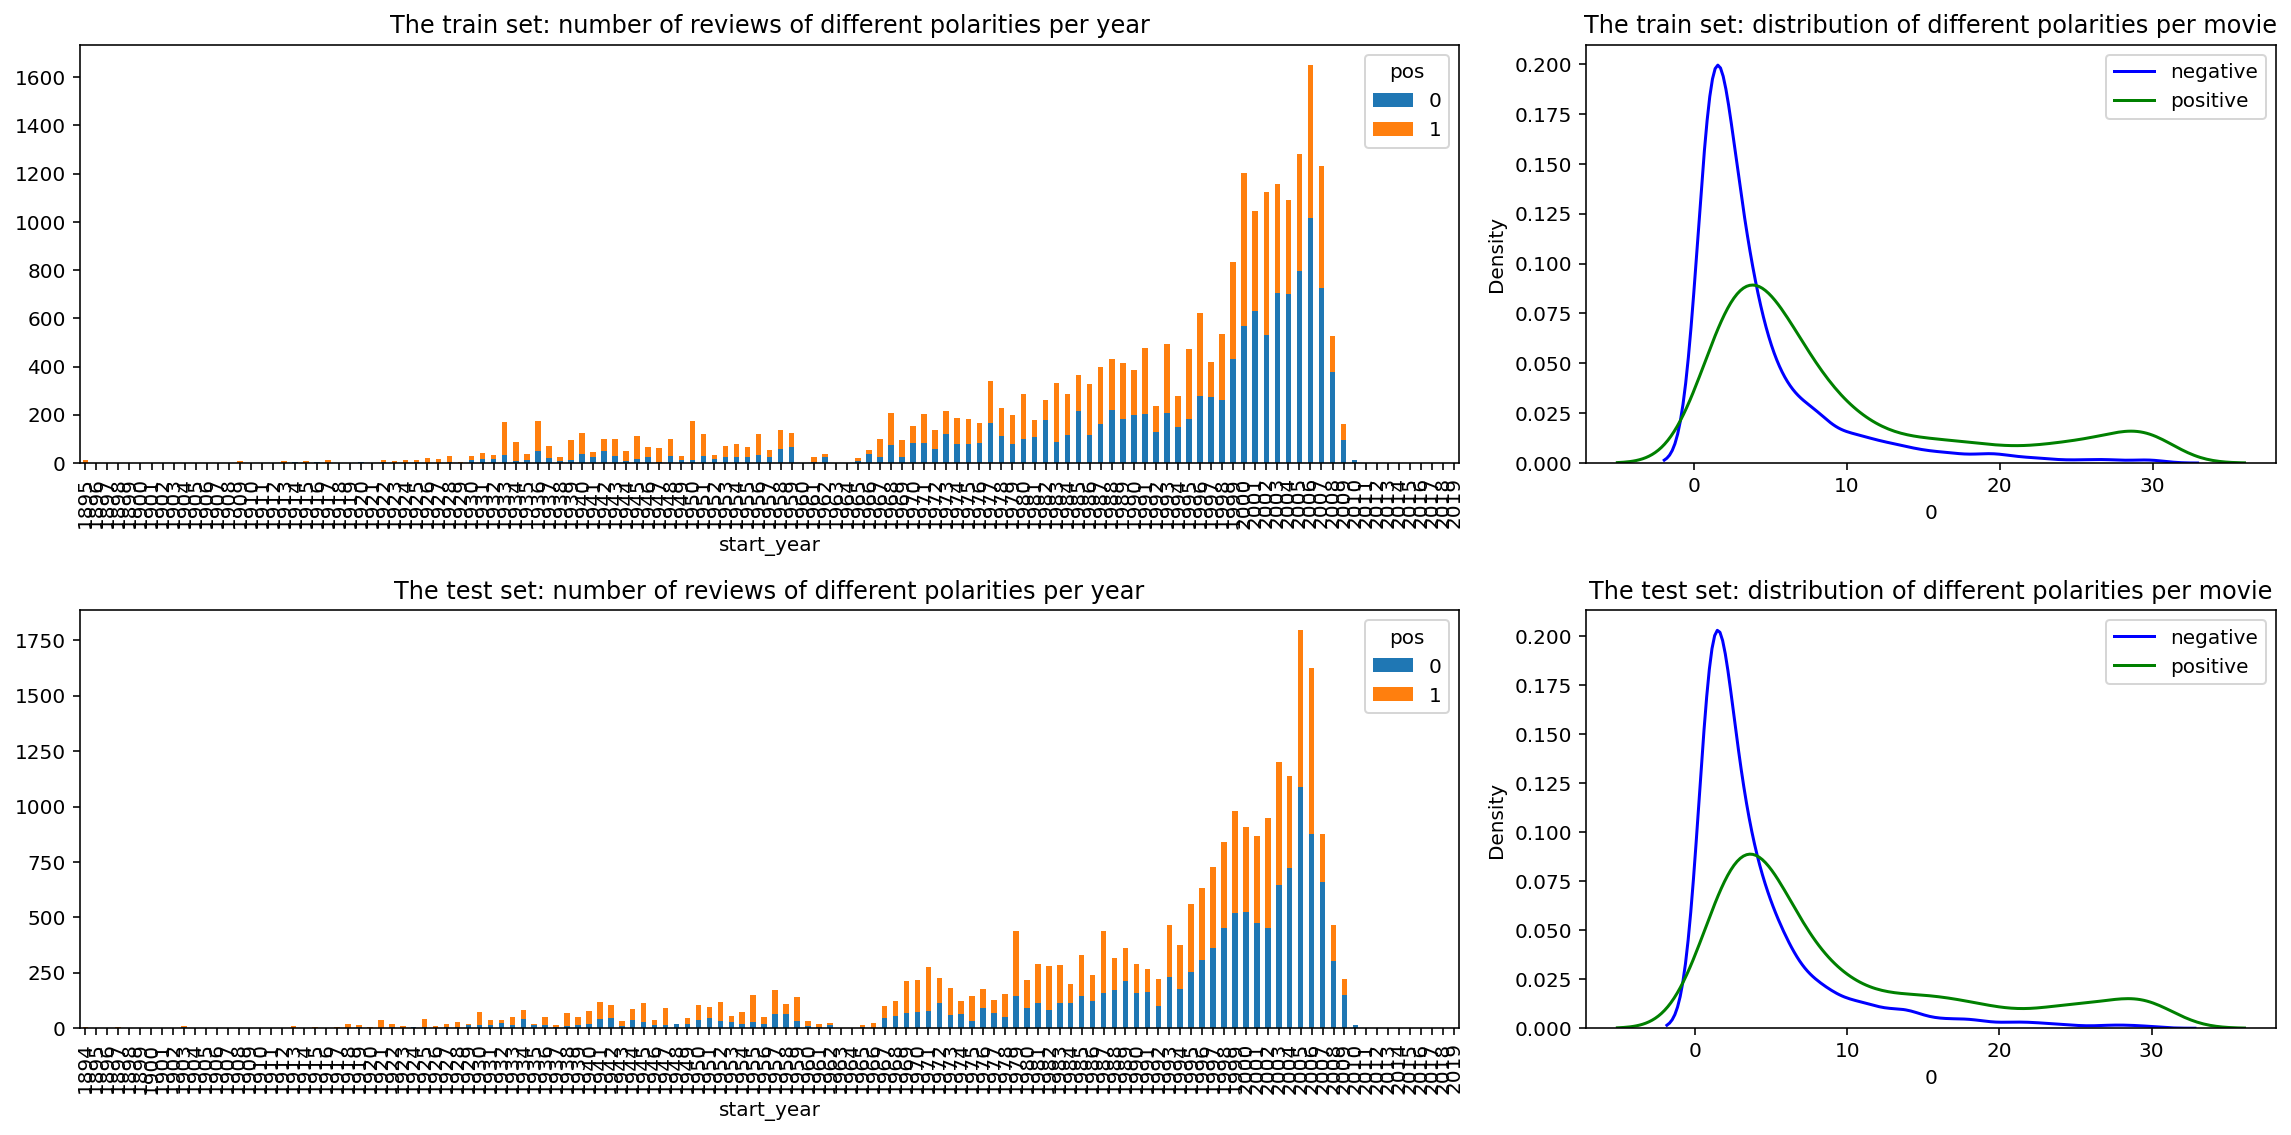

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Number of positive and negative reviews trend similarly over time and are also similarly distributed in the training and testing data sets. 
The KDE plots for both sets show that distributions seem to be skewed towards the right, so most movies have relatively few reviews, and only a small number of movies have a large number of reviews.
The skewness in the distribution of reviews per movie suggests that the dataset might contain a lot of information about a few popular movies, while less popular movies are under-represented. This could potentially bias the sentiment analysis model towards the opinions expressed in reviews of popular movies.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [17]:
import re

def normalize_text(text):
    # Remove digits and punctuation from lowercased text
    text = re.sub(r'\d|[^\w\s]', '', text.lower(), flags=re.UNICODE)
    return text

In [18]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

In [19]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um  a serious film about troubled teens in sin...
4    im totally agree with garryjohal from singapor...
Name: review_norm, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [21]:
from sklearn.dummy import DummyClassifier

In [22]:
# Dummy model that always predicts negative sentiment
model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(df_reviews_train, train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


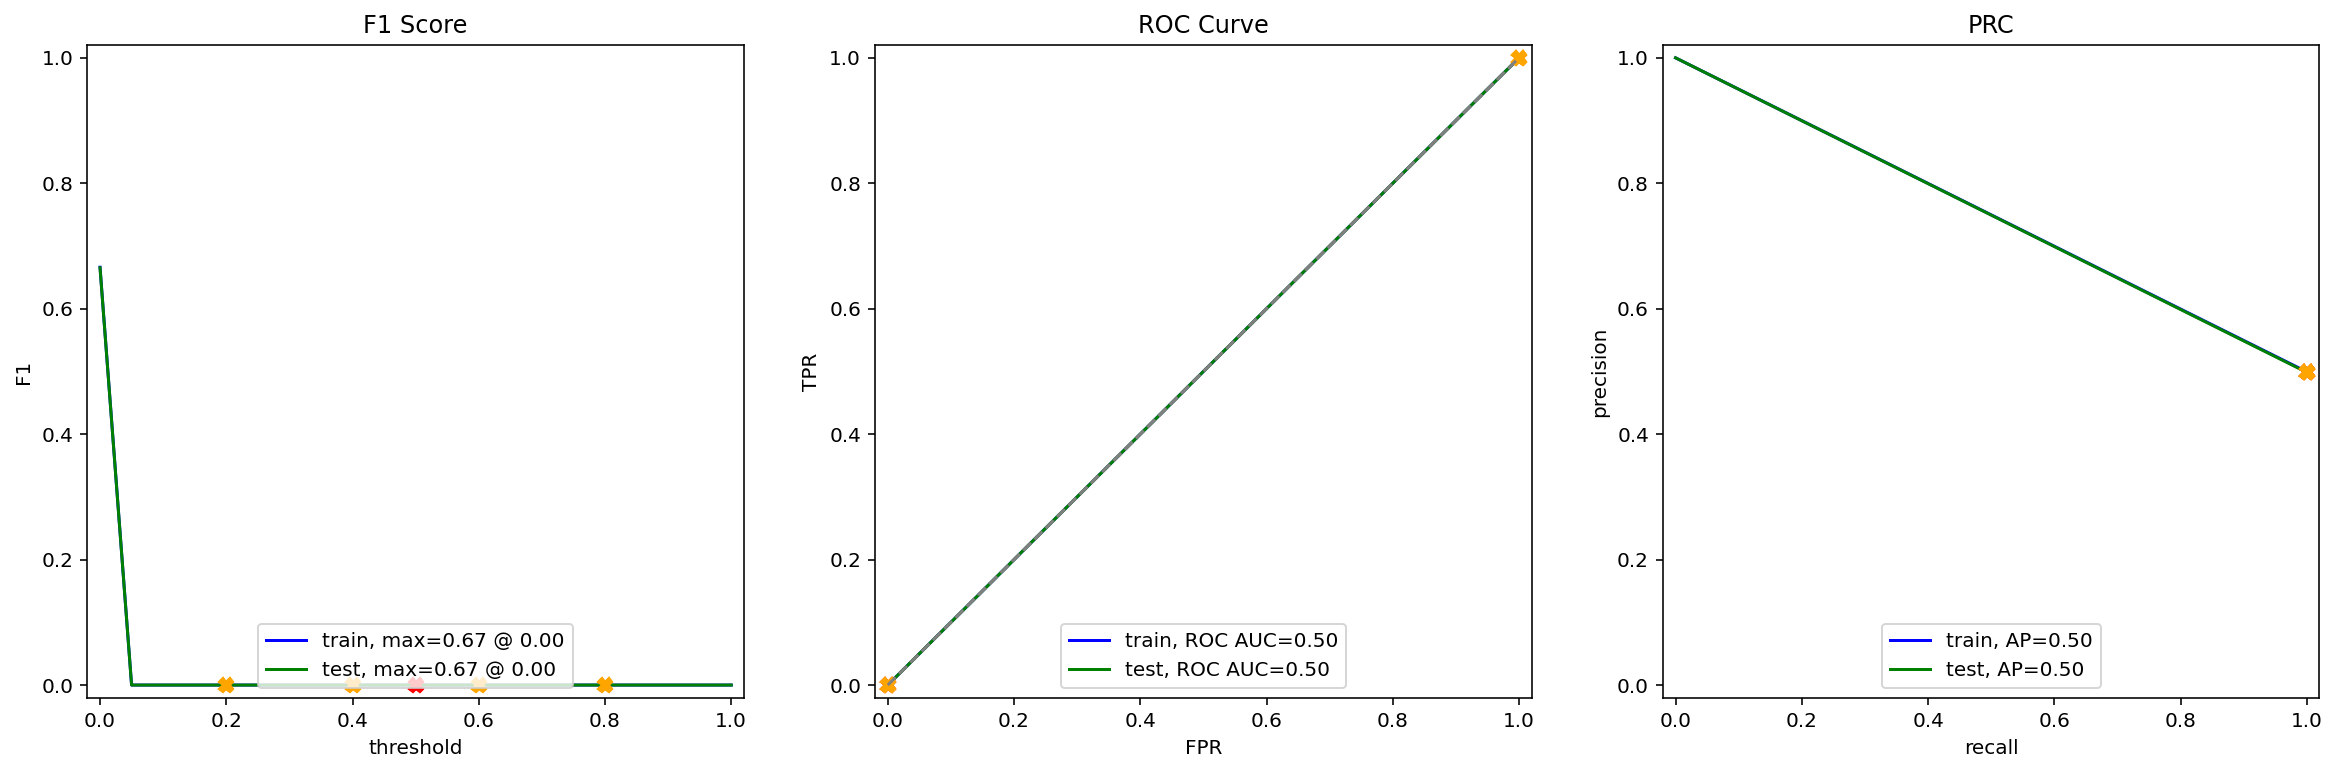

In [23]:
evaluate_model(model_0, df_reviews_train, train_target, df_reviews_test, test_target)

As expected, a dummy model that always predicts negative sentiment has F1 score of 0 for both sets, low precision, and performs as good as random guessing

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [24]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...


True

In [25]:
train_features_1 = df_reviews_train['review_norm'].copy()
test_features_1 = df_reviews_test['review_norm'].copy()

In [26]:
# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define the set of stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess normalized text
def preprocess_text(text):
    
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize the words
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join the tokens back into a single string and return it
    return ' '.join(tokens)

# Apply the preprocessing to the review text
train_features_1 = train_features_1.apply(preprocess_text)
test_features_1 = test_features_1.apply(preprocess_text)

In [27]:
tfidf_vectorizer_1 = TfidfVectorizer()
tf_idf_train_1 = tfidf_vectorizer_1.fit_transform(train_features_1)

tf_idf_test_1 = tfidf_vectorizer_1.transform(test_features_1)

In [28]:
model_1 = LogisticRegression()
model_1.fit(tf_idf_train_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


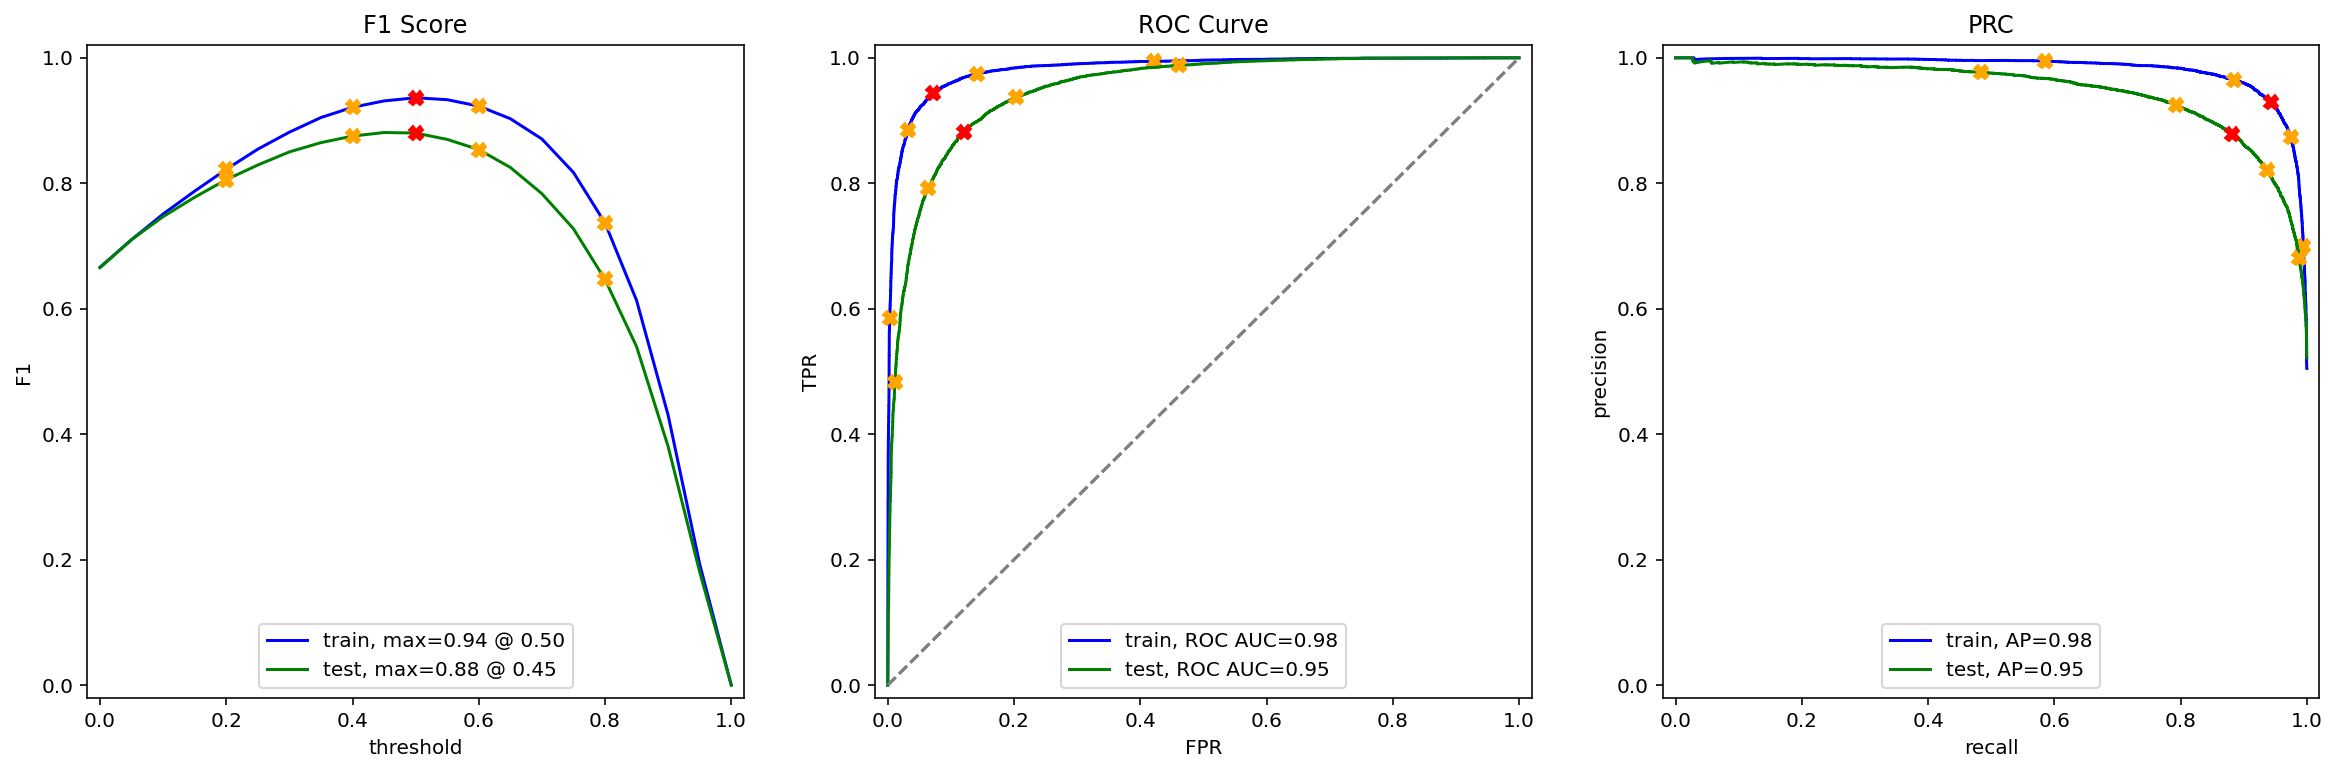

In [29]:
evaluate_model(model_1, tf_idf_train_1, train_target, tf_idf_test_1, test_target)

This model exceeds minimum F1 threshold of 0.85, has good precision, recall, and distinguishes between classes across a range of thresholds. The slightly lower scores on the test set compared to the training set indicate there may be a small amount of overfitting.

### Model 2 - spaCy, TF-IDF and LR

In [30]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [31]:
# Function to preprocess normalized text
def preprocess_text_spacy(text):
    
    # Process the text
    doc = nlp(text)

    # Tokenize, lemmatize, and remove stop words
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [32]:
train_features_2 = df_reviews_train['review_norm'].copy()
test_features_2 = df_reviews_test['review_norm'].copy()

In [33]:
# Apply the preprocessing to the review text
train_features_2 = train_features_2.apply(preprocess_text_spacy)
test_features_2 = test_features_2.apply(preprocess_text_spacy)

In [34]:
tfidf_vectorizer_2 = TfidfVectorizer()
tf_idf_train_2 = tfidf_vectorizer_2.fit_transform(train_features_2)

tf_idf_test_2 = tfidf_vectorizer_2.transform(test_features_2)

In [35]:
model_2 = LogisticRegression()
model_2.fit(tf_idf_train_2, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


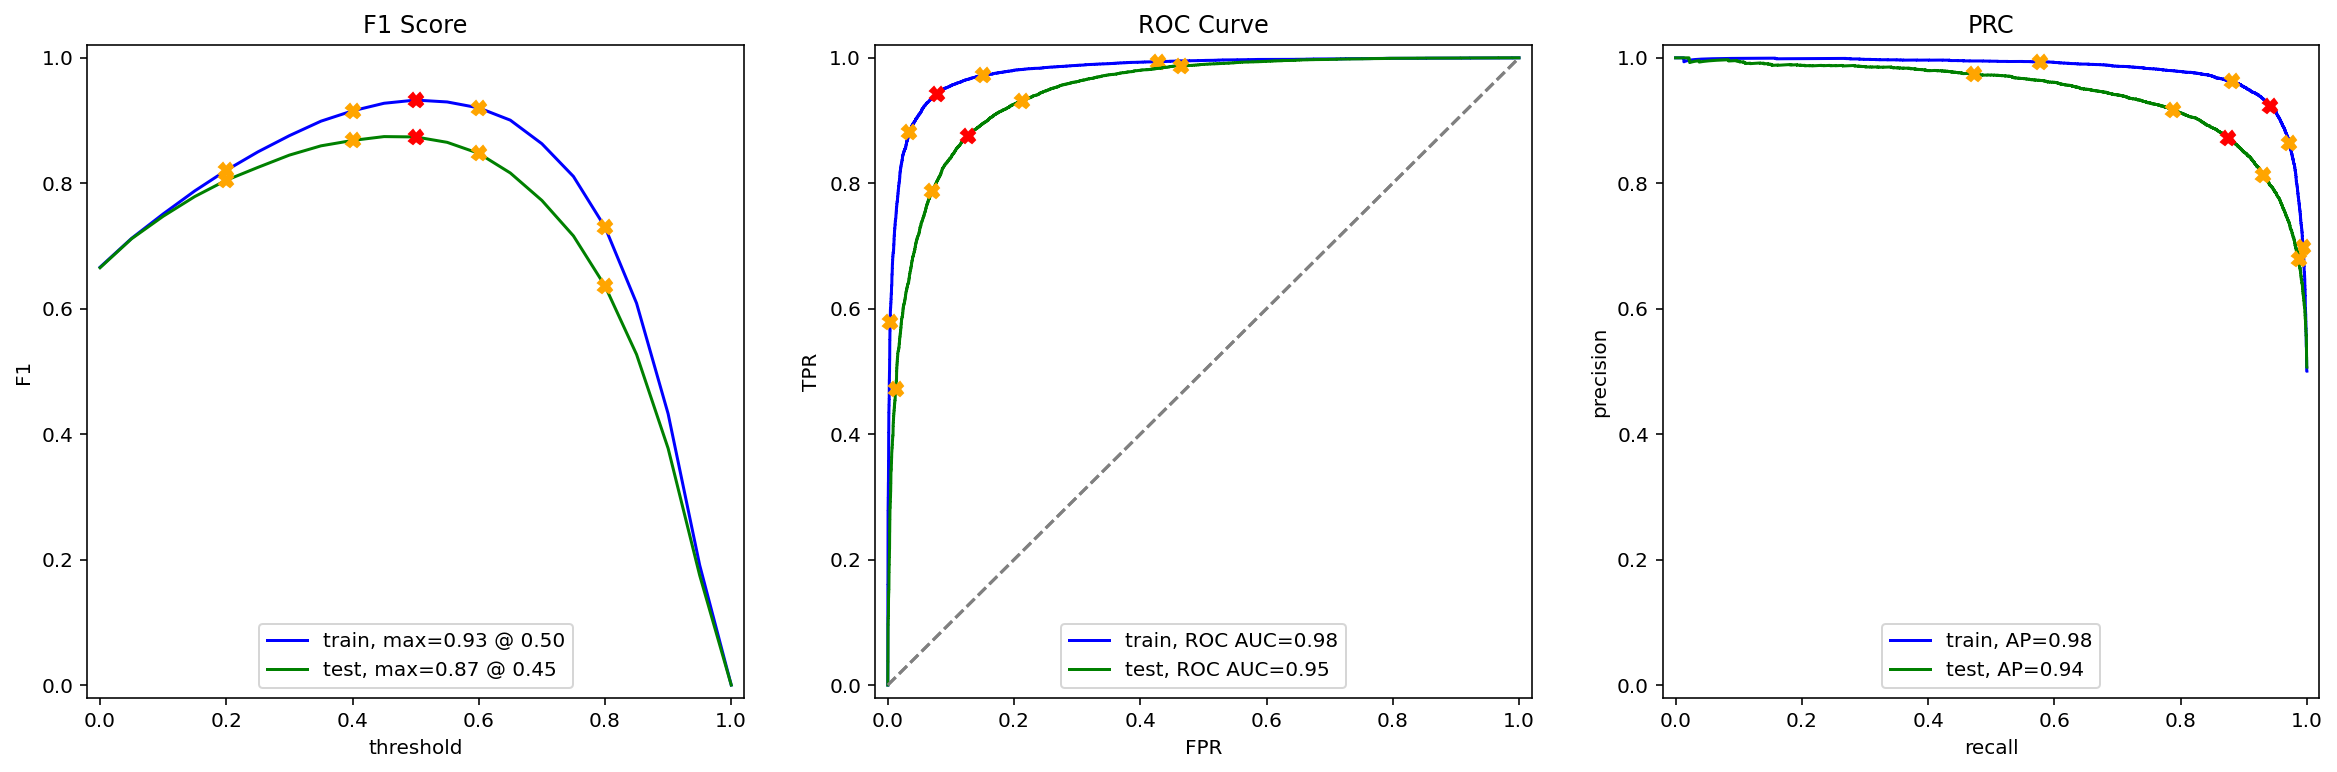

In [36]:
evaluate_model(model_2, tf_idf_train_2, train_target, tf_idf_test_2, test_target)

Model 2 has similar metrics to model 1 (NLTK, TF-IDF and LR) and performs very well and exceeds minimum F1 threshold of 0.85. Same issue with overfitting due to lower scores on test vs train sets.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [37]:
from lightgbm import LGBMClassifier

In [38]:
# spaCy preprocessing done in step above, using same features
tf_idf_train_3 = tf_idf_train_2
tf_idf_test_3 = tf_idf_test_2

model_3 = LGBMClassifier()
model_3.fit(tf_idf_train_3, train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


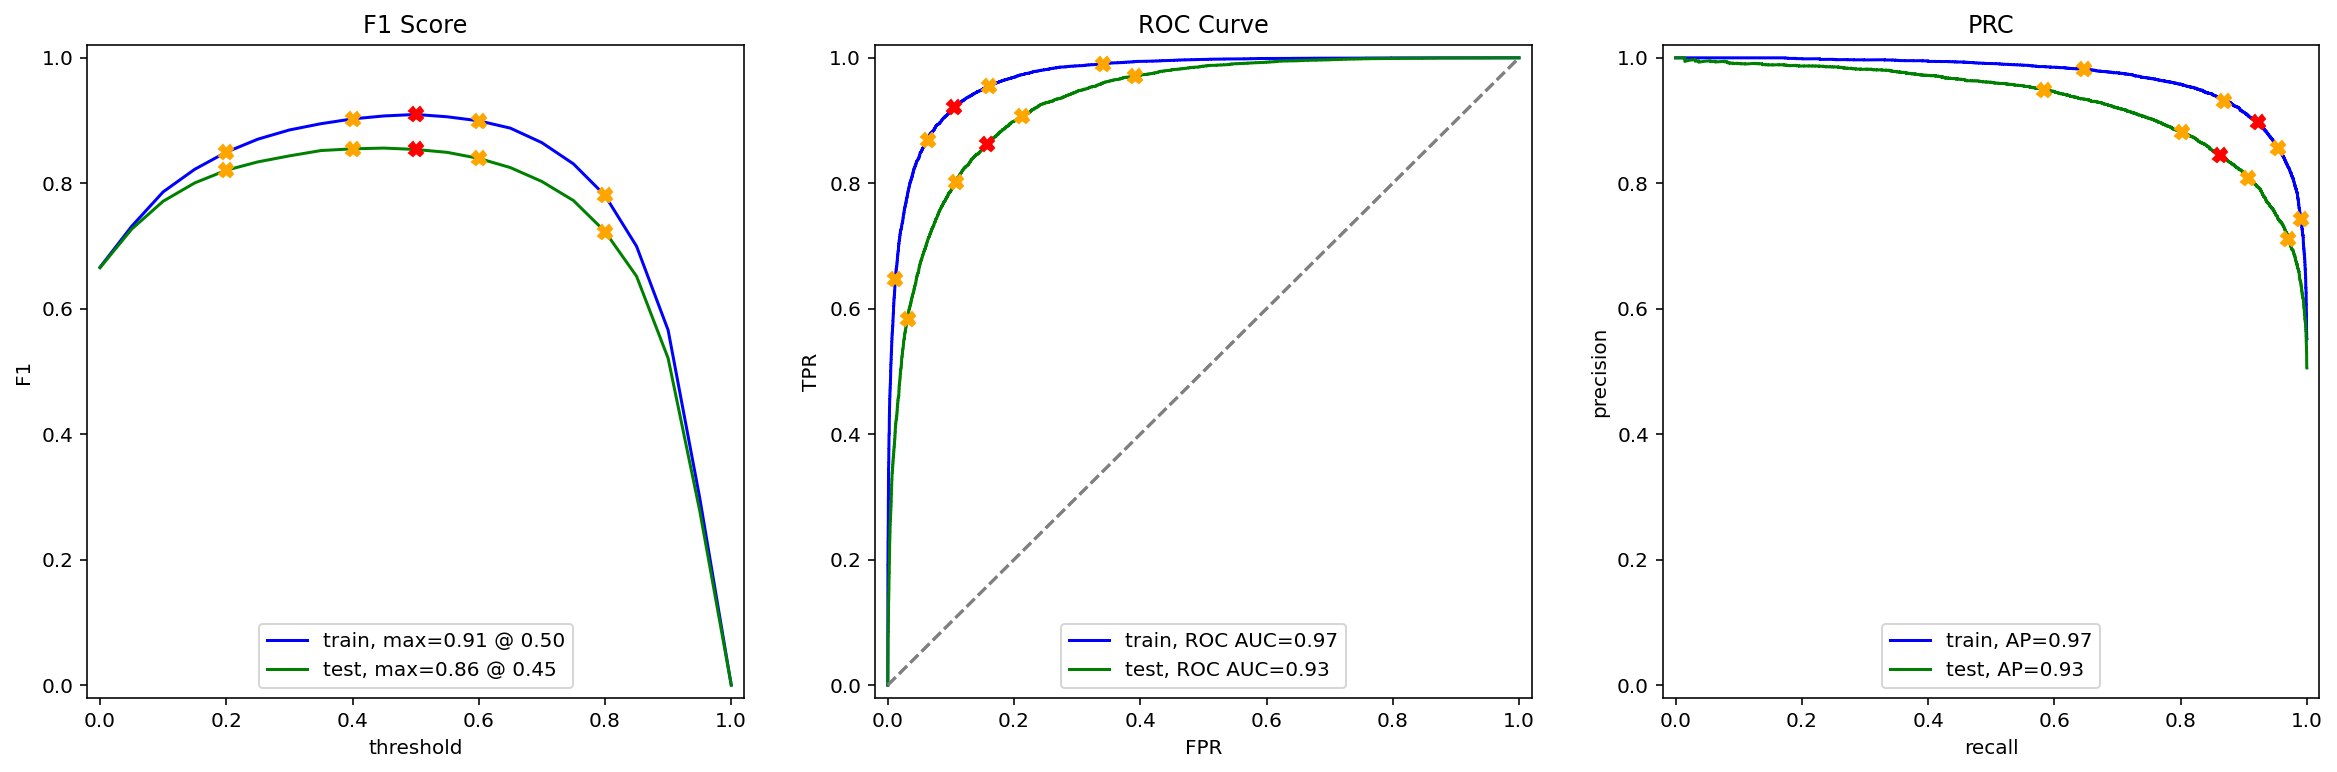

In [39]:
evaluate_model(model_3, tf_idf_train_3, train_target, tf_idf_test_3, test_target)

Model 3 is right at 0.85 for F1, which is the minimum required. It performs slightly worse than model 1 (NLTK, TF-IDF and LR) and model 2 (spaCy, TF-IDF and LR). Same issue with overfitting due to lower scores on test vs train sets.

###  Model 4 - BERT

In [40]:
import torch
import transformers

In [41]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    for input_text in texts:
        ids = tokenizer.encode(
            input_text.lower(),
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
        )
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask) 
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [43]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_4 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [44]:
#test_features_4 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

In [45]:
# Save embeddings produced by BERT
#np.savez_compressed('features_4.npz', train_features_4=train_features_4, test_features_4=test_features_4)

In [46]:
# Load embeddings data
data = np.load('features_4.npz')
train_features_4 = data['train_features_4']
test_features_4 = data['test_features_4']

In [47]:
print(df_reviews_train['review_norm'].shape)
print(train_features_4.shape)
print(train_target.shape)
print(test_features_4.shape)
print(test_target.shape)

(23796,)
(23796, 768)
(23796,)
(23535, 768)
(23535,)


### BERT and LR

In [48]:
model_4 = LogisticRegression()
model_4.fit(train_features_4,train_target)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

          train  test
Accuracy   0.87  0.86
F1         0.87  0.86
APS        0.95  0.94
ROC AUC    0.95  0.94


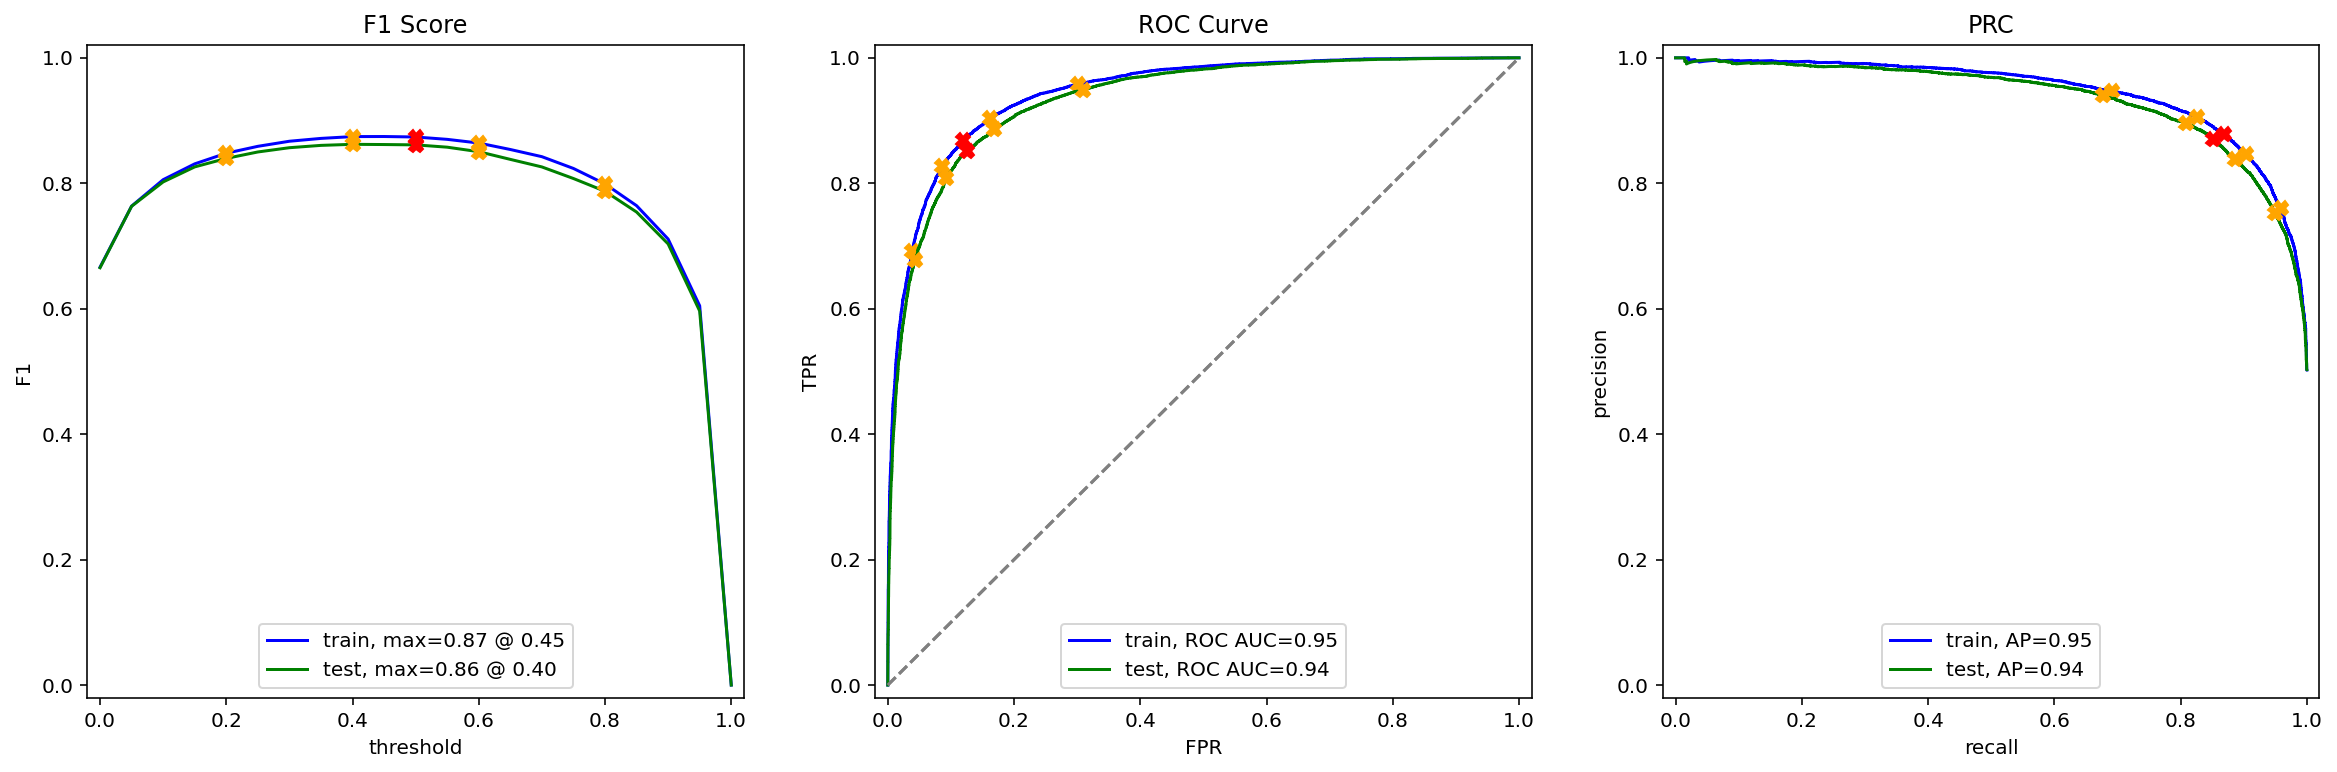

In [49]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

Model 4 performs better than model 3 (spaCy, TF-IDF and LGBM) but slightly worse than model 1 (NLTK, TF-IDF and LR) and model 2 (spaCy, TF-IDF and LR). The metrics for train and test data sets are very close, which indicates the model is less overfitted than any previous models.

### Model 5 - BERT and LGBMClassifier

In [50]:
# BERT embeddings created in step above, using same features
train_features_5 = train_features_4
test_features_5 = test_features_4

model_5 = LGBMClassifier()
model_5.fit(train_features_5,train_target)

LGBMClassifier()

          train  test
Accuracy   0.92  0.83
F1         0.92  0.83
APS        0.98  0.91
ROC AUC    0.98  0.91


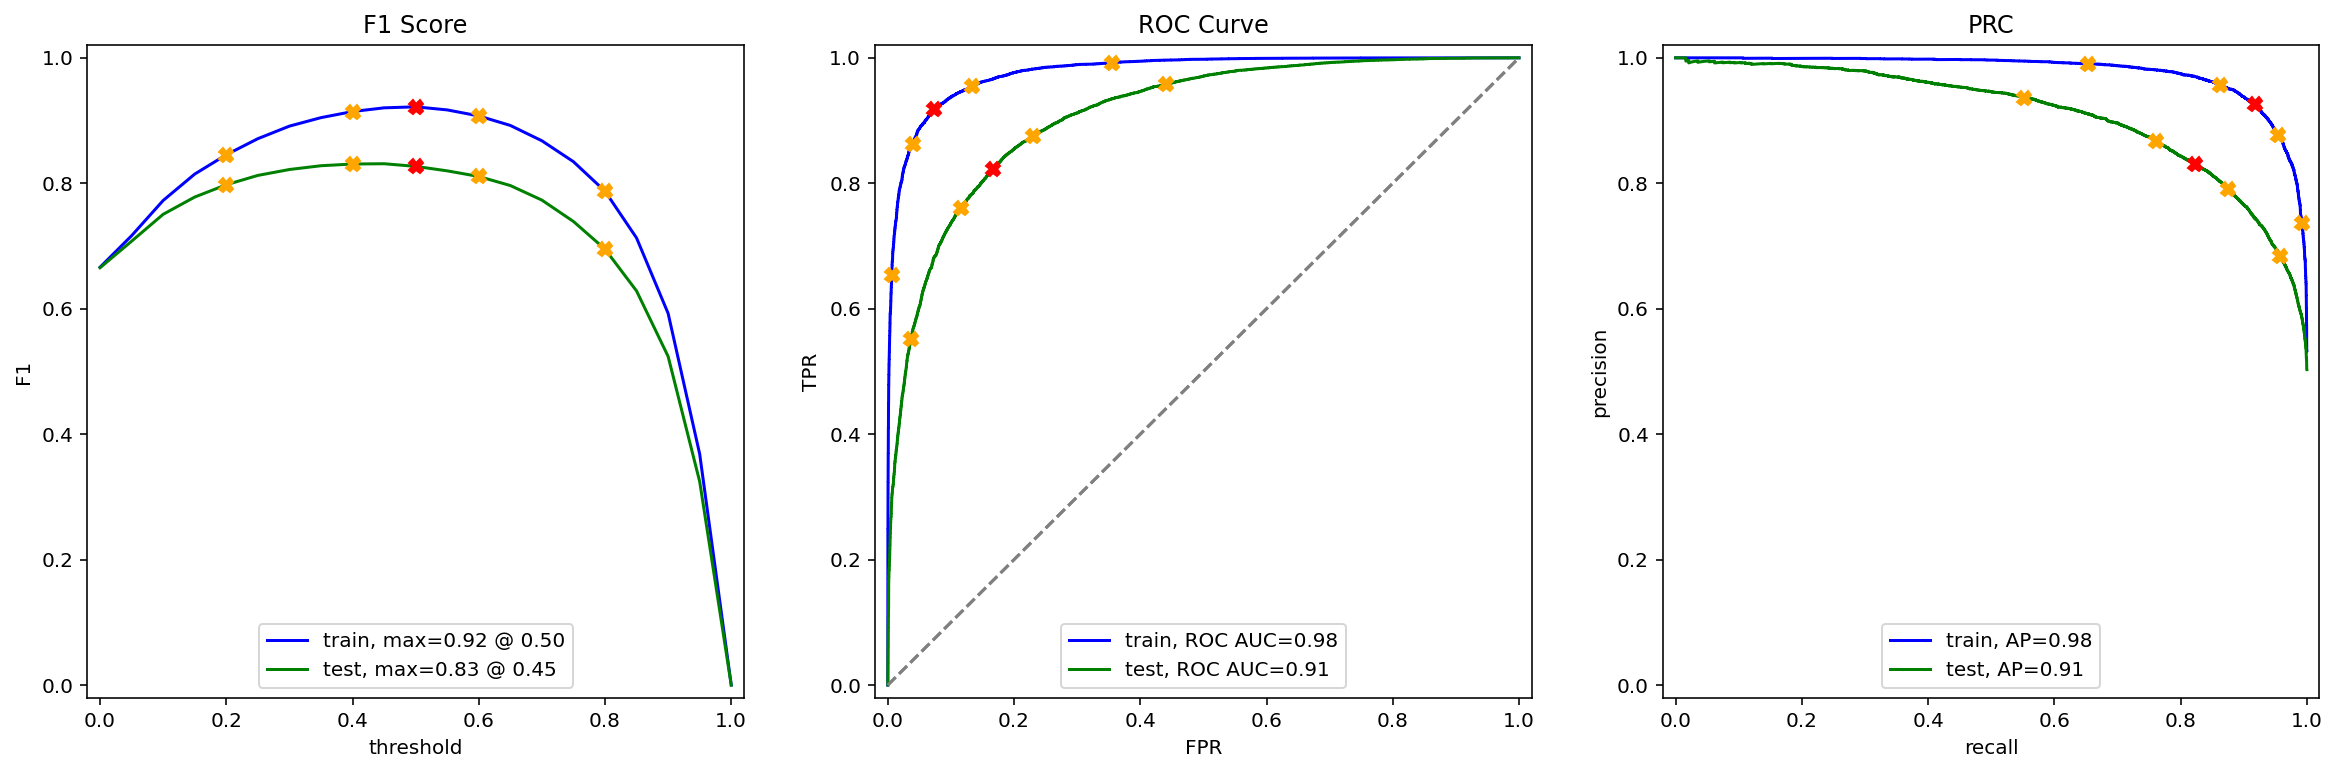

In [51]:
evaluate_model(model_5, train_features_5, train_target, test_features_5, test_target)

Model 5 performs worse than models 1, 2, 3, 4, and fails to meet the minimum F1 score of 0.85. There's potentially overfitting issue as well.

## My Reviews

In [52]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and fell asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and fell asleep in the middl...",well i was bored and fell asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 1 - NLTK, TF-IDF and LR

In [53]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.32:  i did not simply like it not my kind of movie
0.24:  well i was bored and fell asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.33:  i didnt expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 2 - spaCy, TF-IDF and LR

In [54]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: preprocess_text_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.06:  well i was bored and fell asleep in the middle of the movie
0.51:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didnt expect the reboot to be so good writers really cared about the source material
0.40:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [55]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = tfidf_vectorizer_2
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: preprocess_text_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  i did not simply like it not my kind of movie
0.28:  well i was bored and fell asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.48:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.47:  i didnt expect the reboot to be so good writers really cared about the source material
0.58:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.19:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 4 - BERT and LR

In [56]:
texts = my_reviews['review_norm']

my_reviews_features_4 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_4)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

/tmp/ipykernel_276/1288810290.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


0.37:  i did not simply like it not my kind of movie
0.02:  well i was bored and fell asleep in the middle of the movie
0.99:  i was really fascinated with the movie
0.01:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.07:  i didnt expect the reboot to be so good writers really cared about the source material
0.99:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.02:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.98:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 5 - BERT and LGBMClassifier

In [57]:
texts = my_reviews['review_norm']

my_reviews_features_5 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_5.predict_proba(my_reviews_features_5)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.69:  i did not simply like it not my kind of movie
0.10:  well i was bored and fell asleep in the middle of the movie
0.70:  i was really fascinated with the movie
0.07:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.39:  i didnt expect the reboot to be so good writers really cared about the source material
0.90:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


BERT with LR is better with new reviews as its predictions are very close to 0 or 1, which indicates its better at discerning sentiment.

## Conclusions

- All models perform better than dummy constant model, which is a good sanity check
- LightGBM peforms worse than LR in TF-IDF and BERT
- Max F1 scores are achieved at thresholds 0.4 to 0.5 for various models, which further confirms that classes in dataset are well balanced.
- Recommendation is to use BERT with LR for best sentiment analysis of new reviews as it is least overfitted, has F1 score higher than 0.85, and performs well on new user generated reviews.